In [ ]:
'''
Combines other dataframes
Uses feature tools for deep feature synthesis
'''

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# imports
from utils import *
from models import *

In [2]:
# read in data - limit to 1000 rows for now
app_train = pd.read_csv('../input/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True)#.loc[:1000, :]
app_test = pd.read_csv('../input/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
bureau = pd.read_csv('../input/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:1000, :]
bureau_balance = pd.read_csv('../input/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:1000, :]



In [3]:
# Combine the train and test to a single df (stack train on test). This means all processing can be done on both in 1 go
# LEAKING MAY BE A ISSUE!
def combine_app_train_test(train, test):
    # Add identifying column
    train['set'] = 'train'
    test['set'] = 'test'
    test["TARGET"] = np.nan

    # Append the dataframes
    app = train.append(test, ignore_index = True)
    return app

app = combine_app_train_test(app_train, app_test)


In [4]:
# Instantiate a entity set (es) which will keep all data. Entity ~ table
es = ft.EntitySet(id = 'clients')

def add_entities(entity_set):
    # Add the different entities (tables) to the entityset
    entity_set = entity_set.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')
    entity_set = entity_set.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

    # For entitites which do not have a unique index column, create one
    # This will update the original dataframe with new indexes 
    entity_set = entity_set.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                                  make_index = True, index = 'bureau_balance_index')
    return entity_set

es = add_entities(es)
es

Entityset: clients
  Entities:
    app [Rows: 308512, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    bureau_balance [Rows: 1001, Columns: 4]
  Relationships:
    No relationships

In [5]:
def add_relationships(entity_set):
    # Relationship between app and bureau
    rel_app_bureau = ft.Relationship(entity_set['app']['SK_ID_CURR'], entity_set['bureau']['SK_ID_CURR'])

    # Relationship between bureau and bureau balance
    rel_bureau_balance = ft.Relationship(entity_set['bureau']['SK_ID_BUREAU'], entity_set['bureau_balance']['SK_ID_BUREAU'])

    # Add in the defined relationships
    entity_set = entity_set.add_relationships([rel_app_bureau, rel_bureau_balance])
    return entity_set

es = add_relationships(es)

In [69]:
# # Default primitives from featuretools
# default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "mode"]
# default_trans_primitives = []
# # default_trans_primitives =  ["day", "year", "month"]

# # DFS with specified primitives
# feature_names = ft.dfs(entityset = es, target_entity = 'app',
#                        trans_primitives = default_trans_primitives,
#                        agg_primitives=default_agg_primitives, 
#                        max_depth = 2, features_only=True)

# print('%d Total Features' % len(feature_names))

243 Total Features


In [6]:
def create_deep_synthetic_features(entity_set, agg_primitives, trans_primitives=[], target_entity='app', max_depth = 2):
    # DFS with default primitives
    features, feature_names = ft.dfs(entityset = entity_set, target_entity = target_entity,
                                           trans_primitives = trans_primitives,
                                           agg_primitives=agg_primitives, 
                                            max_depth = 2, features_only=False, verbose = True)

    # pd.options.display.max_columns = 1700
#     features.head(10)
    return features

default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "mode"]
default_trans_primitives = []
ds_features = create_deep_synthetic_features(es, default_agg_primitives, default_trans_primitives)

Built 243 features
Elapsed: 00:08 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 11/11 chunks
            AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
SK_ID_CURR                                                               
100001          20560.5    568800.0         450000.0          135000.0   
100002          24700.5    406597.5         351000.0          202500.0   
100003          35698.5   1293502.5        1129500.0          270000.0   
100004           6750.0    135000.0         135000.0           67500.0   
100005          17370.0    222768.0         180000.0           99000.0   
100006          29686.5    312682.5         297000.0          135000.0   
100007          21865.5    513000.0         513000.0          121500.0   
100008          27517.5    490495.5         454500.0           99000.0   
100009          41301.0   1560726.0        1395000.0          171000.0   
100010          42075.0   1530000.0        1530

[10 rows x 243 columns]


In [7]:
from featuretools import selection
# Remove features with only one unique value
all_ds_features = ds_features
ds_features = selection.remove_low_information_features(ds_features)

print('Removed %d features' % (all_ds_features.shape[1]- ds_features.shape[1]))

Removed 35 features


In [8]:
# Separate out the train and test sets
train = ds_features[ds_features['set'] == 'train']
test = ds_features[ds_features['set'] == 'test']

# # One hot encoding
# train = pd.get_dummies(train)
# test = pd.get_dummies(test)

# # Align dataframes on the columns
# train, test = train.align(test, join = 'inner', axis = 1)
train = train.drop(columns = ['set'])

test = test.drop(columns = ['TARGET'])
test = test.drop(columns = ['set'])

print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (307511, 207)
Testing Shape:  (1001, 206)


ONE HOT ENCODED
Training Features shape:  (307511, 336)
Testing Features shape:  (1001, 313)
ALIGNED:
Training Features shape:  (307511, 314)
Testing Features shape:  (1001, 313)
There were 182 anomalies in the test data out of 1001 entries
Training Features shape:  (307511, 236)
Testing Features shape:  (1001, 314)
Training Features shape:  (307511, 236)
Testing Features shape:  (1001, 235)


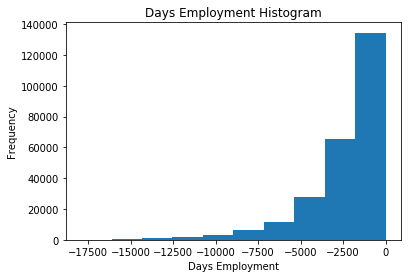

In [20]:
# do basic pre-processing
def pre_process(train_data, test_data):
#     train_data, test_data = encode_binary_cols(train_data, test_data) # purposefully left out - was taking too long
    train_data, test_data = one_hot_encode(train_data, test_data)
    train_data, test_data, train_Y = align_data(train_data, test_data)
    train_data, test_data = remove_days_employed_anomaly(train_data, test_data)
    train_data, test_data = remove_missing_cols(train_data, test_data)
    
    train_data = mean_impute(train_data)
    test_data = mean_impute(test_data)

    return train_data, test_data

train_data, test_data = pre_process(train, test)

In [22]:
# Do final processing to get aligned train and test set with training labels 
train_X, test_X , train_Y= align_data(train_data, test_data)
train_X = train_X.drop(columns=['TARGET'])
# train_X = train_X.drop(columns=['SK_ID_CURR'])
# test_X = test_X.drop(columns=['SK_ID_CURR'])
print('Training Data Shape: ', train_X.shape)
print('Testing Data Shape: ', test_X.shape)
feature_names = train_X.columns
# train_X, train_Y = oversample(train_X, train_Y)
train_X, test_X = normalise(train_X, test_X)

ALIGNED:
Training Features shape:  (307511, 236)
Testing Features shape:  (1001, 235)
Training Data Shape:  (307511, 235)
Testing Data Shape:  (1001, 235)


C:\Users\Bhumika\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


NORMALISED:
Training data shape:  (307511, 235)
Testing data shape:  (1001, 235)


Run 0 AUC socre: 0.6874635948044611
Run 1 AUC socre: 0.682588631305188
Run 2 AUC socre: 0.6836251562466884
Run 3 AUC socre: 0.6915692043006093
Run 4 AUC socre: 0.6776297789995207
Run 5 AUC socre: 0.6793329442934708
Avg ROC AUC score: 0.683701551658323


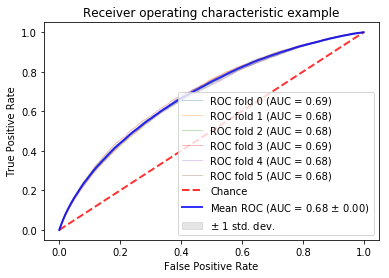

In [23]:
model, predictions = baseline_log_reg(train_X, train_Y, test_X, save_path=None) # don't save model
cross_val_roc_curve(train_X, train_Y.values, model)